# Drought Network Version 1.1 Test
a. stein 2.28.23

This notebook serves as a testing space for cleaning up `drought_network.py` and attempting to improve its functionality.

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import pandas as pd
import geopandas as gpd

import matplotlib.dates as mdates

from tqdm.autonotebook import tqdm

import sys
sys.path.append('../../')
from ndrought import drought_network_v12 as dnet_test

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/tmp/ipykernel_4018507/978642154.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Let's get our simpler test case up in here.

In [2]:
def tick(matrix):
    new_state = np.copy(matrix)

    i_dim, j_dim = matrix.shape

    for i in range(i_dim):
        for j in range(j_dim):
            north = matrix[i][j-1] if j>0 else 0
            south = matrix[i][j+1] if j<(j_dim-1) else 0
            west = matrix[i+1][j] if i<(i_dim-1) else 0
            east = matrix[i-1][j] if i>0 else 0
            se = matrix[i+1][j+1] if i<(i_dim-1) and j<(j_dim-1) else 0
            sw = matrix[i+1][j-1] if i<(i_dim-1) and j>0 else 0
            ne = matrix[i-1][j+1] if i>0 and j<(j_dim-1) else 0
            nw = matrix[i-1][j-1] if i>0 and j>0 else 0
            neighbors = np.sum([north, south, west, east, se, sw, ne, nw])

            # rules
            if matrix[i][j] == 0 and neighbors == 3: # reproduction
                new_state[i][j] = 1
            elif matrix[i][j] == 1 and neighbors < 2: # underpopulation
                new_state[i][j] = 0
            elif matrix[i][j] == 1 and neighbors > 3: # overpopulation
                new_state[i][j] = 0
            elif matrix[i][j] == 1 and neighbors == 2: # survives
                new_state[i][j] = 1
            elif matrix[i][j] == 1 and neighbors == 3: # also survives
                new_state[i][j] = 1

    return new_state

In [3]:
# this was originally generated randomly using the same method method as
# before, but I have now hard coded it to have a consistent test example
test_matrix = np.array([
    [0, 0, 0, 0, 0],
    [0, 1, 1, 0, 1],
    [1, 1, 0, 0, 1],
    [1, 1, 1, 0, 1],
    [0, 0, 1, 0, 1]
])

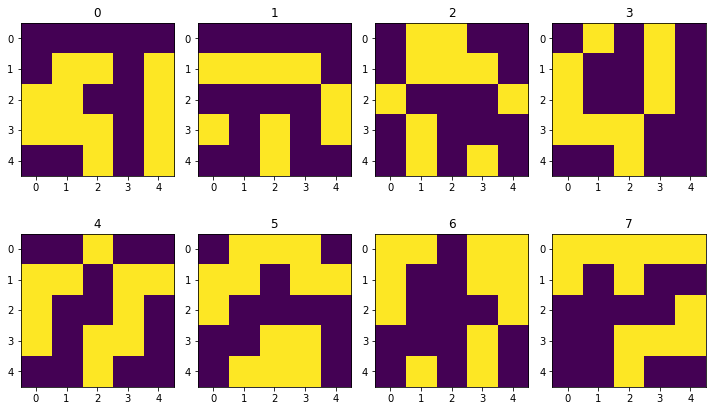

In [4]:
fig, axs = plt.subplots(2, 4, figsize=(10,6))

test_series = []
plot_matrix = test_matrix

for i, ax in enumerate(axs.ravel()):
    test_series.append(plot_matrix)
    ax.imshow(plot_matrix)
    plot_matrix = tick(plot_matrix)

    ax.set_title(i)

plt.tight_layout()

In [5]:
test_series = np.array(test_series)

In [6]:
test = dnet_test.DroughtNetwork(test_series, area_threshold=2)

Creating Network: drought_network:   0%|          | 0/8 [00:00<?, ?it/s]

In [7]:
for node in test.nodes:
    print(node.id)

0
1
2
3
4
5
6
7
8
9
10
11


In [8]:
trimmed = test.to_array()

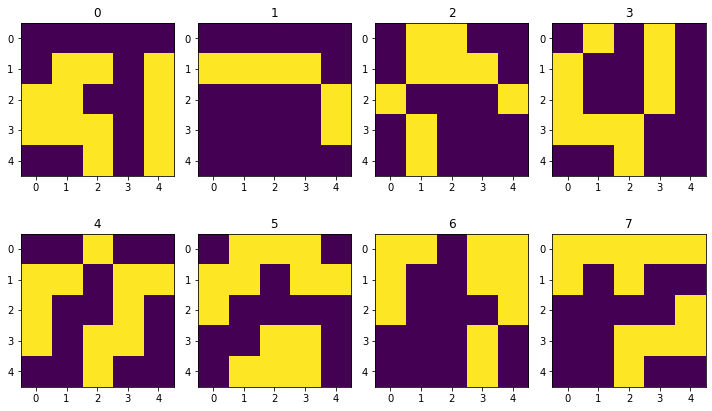

In [9]:
fig, axs = plt.subplots(2, 4, figsize=(10,6))


for i, ax in enumerate(axs.ravel()):
    ax.imshow(trimmed[i, :, :])

    ax.set_title(i)

plt.tight_layout()

In [10]:
test.nodes[0].area

8

Let's apply this to SPI and see if our things end up running

In [11]:
spi_14d = dnet_test.DroughtNetwork.unpickle('/pool0/home/steinjao/data/drought/drought_impact/data/drought_measures/ndrought_products/CONUS_105W/individual_dnet/spi_14d_net.pickle')

Pretty sure that `area` is cell count, let's double check

In [14]:
spi_14d.nodes[0].area

5

Yeah that's definitely not m2, so it's cell count

In [15]:
areas = [node.area for node in spi_14d.nodes]

In [16]:
from ndrought import wrangle

In [18]:
sorted, pos = wrangle.cunnane_empircal_cdf(areas)

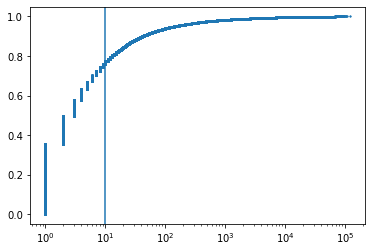

In [25]:
fig, ax = plt.subplots()

ax.scatter(sorted, pos, s=1)
ax.set_xscale('log')
ax.axvline(10)